## Домашнее задание
Рассмотрим граф G=(V,E), вершинам которого случайным образом приписаны значения 0 и 1 так, что смежные вершины не могут одновременно иметь значение 1.![img](http://www.mathematik.uni-ulm.de/stochastik/lehre/ss06/markov/skript_engl/bild4.jpg)

Как оценить, сколько в среднем закрашенных вершин будет иметь такой граф?

Сформулируем задачу в математических терминах.

Пусть $\xi \in \{0,1\}^{V}$ обозначает конфигурацию графа (расстановку 0 и 1 по вершинам). Назовем конфигурацию допустимой, если вершины, соединенные ребрами, не имеют одновременно значения 1. Пусть $Z_G$ - общее количество допустимых конфигураций. Зададим  распределение на множестве всех конфигураций:
$$\begin{equation*}
\mu(\xi) = 
 \begin{cases}
   \frac{1}{Z_G}, &\text{$\xi$ - допустимая конфигурация}\\
   0, &\text{иначе.}
 \end{cases}
\end{equation*}$$
Обозначим $n(\xi)$ - число закрашенных вершин в конфигурации $\xi$. Тогда
$$
{\rm E} n(\xi) = \sum\limits_{x \in \{0,1\}^V} n(x) \mu(x) = \frac{1}{Z_G} \sum\limits_{x \in \{0,1\}^V} n(x) {\rm I}_{\{x - \text{допустимая} \}}
$$

Явно перебирать все $x \in \{0,1\}^{V}$ не представляется возможным. Мы могли бы попробовать оценить ${\rm E} n(\xi)$, используя закон больших чилел:
$$
{\rm E} n(\xi) \approx \frac{1}{N} \sum\limits_{i=1}^{N} n(\xi), \text{где $\xi \sim \mu$}
$$
Но есть проблема: как смоделировать случайную величину из распределения $\mu$?

В этом нам поможет метод MCMC.

In [1]:
#Вспомогательная функция для раскраски вершин графа в соответствии с переданной маской:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


def plot_grid(narr):
    '''Plots 2d lattice with vertices colored in black and red according to given mask.
    Vertice is colored black if narr[i, j] == True and red otherwise.
    
    Parameters
    ----------
    narr : 2d boolean ndarray
        Mask for vertices colors
    '''

    if narr.dtype != 'bool':
        raise ValueError('narr should be a boolean ndarray')
    colors = np.empty(narr.shape, dtype='U5')
    colors[:] = 'red'
    colors[narr] = 'black'
    x, y = np.indices((narr.shape))
    plt.scatter(x, y, c=colors.ravel())
    plt.show()

In [2]:
def value(current, **kwargs):
    _ = kwargs
    return current.sum()

In [3]:
def proposal(current, indices, **kwargs):
    _ = kwargs
    i=np.random.choice(8,2)
    if current[i[0]][i[1]] == 1:
        return current
    s=0
    if i[0]!=0:
        s+=current[i[0]-1][i[1]]
    if i[0]!=7:
        s+=current[i[0]+1][i[1]]
    if i[1]!=0:
        s+=current[i[0]][i[1]-1]
    if i[1]!=7:
        s+=current[i[0]][i[1]+1]
    
    if s==0:
        current[i[0]][i[1]] = 1
    return current

In [4]:
def metroplis(start, value, proposal, niter, nburn=0, **kwargs):
    current = start
    post = [0]
    for i in range(niter):
        indices = np.random.choice(8,2)
        p = value(current, **kwargs)
        proposed = proposal(current, indices, **kwargs)       
        p /= value(proposed, **kwargs)
        if np.random.rand() > p:
            current = proposed
        else:
            current[indices[0]][indices[1]]=0
        post.append(current.sum())
    plot_grid(current.astype('bool'))
    return post[nburn:]

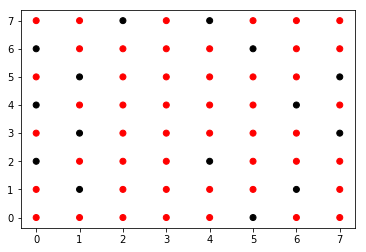

Quantity of coloured vertices estimation: 15.37540624593754


In [5]:
post = metroplis(np.zeros((8,8)), value, proposal, 100000)
print('Quantity of coloured vertices estimation:',sum(post)/len(post))

In [8]:
def g_test(x, start=0.1, end=0.1):
    return stats.ttest_ind(x[:int(len(x) * start)], x[-int(len(x) * end):], equal_var=False)

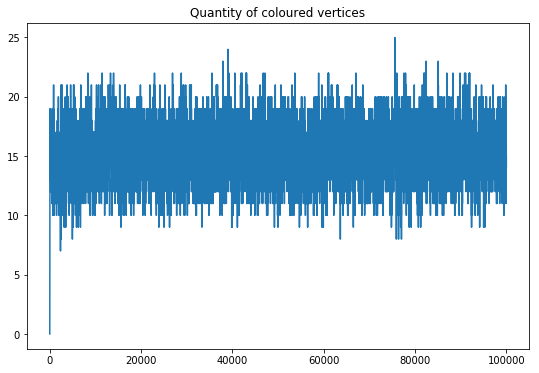

Ttest_indResult(statistic=-3.297064432411927, pvalue=0.0010004653551743457)

In [13]:
plt.figure(figsize = (9,6))
plt.plot(post)
plt.title("Quantity of coloured vertices")
plt.show()
g_test(post[2010:10000])

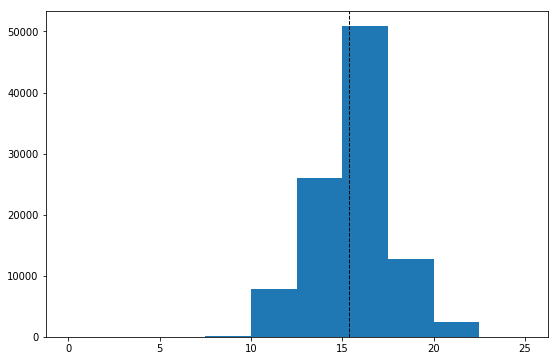

In [14]:
plt.figure(figsize = (9,6))
plt.hist(post)
plt.axvline(np.asarray(post).mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()